# **Image Classification with ConvNeXt**

Written By: Tharnarch Thoranisttakul

This project is for the internship program in Japan at Kanazawa University.

The topic is as stated above. Firstly, we will take a look at classifying image with ConvNeXt. Then, we will take a look at classifying image with Transformers (if we have time then we will take a look at Transformers).

Right now, we will only focus on **ConvNeXt**.

## **Data Exploration**

The task from this lab was to use **CIFAR-100** as the dataset for image classification

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from tqdm.notebook import tqdm
from PIL import Image
import json
import glob
import os

%matplotlib inline

# Import scikit-learn libraries and packages
from sklearn.preprocessing import LabelEncoder

# Import PyTorch libraries and packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms

# For Importing models from HuggingFace
from transformers import AutoModelForImageClassification

from modules import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Load the data
train = unpickle('data/cifar-100-python/train')
test = unpickle('data/cifar-100-python/test')

In [4]:
print(f'Train Keys: {train.keys()}\nTest Keys: {test.keys()}')
print('-'*20)
print(f'Train Data Shape: {train[b"data"].shape}\nTest Data Shape: {test[b"data"].shape}')
print('-'*20)
print(f'Train Data Type: {type(train[b"data"])}\nTest Data Type: {type(test[b"data"])}')

Train Keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
Test Keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
--------------------
Train Data Shape: (50000, 3072)
Test Data Shape: (10000, 3072)
--------------------
Train Data Type: <class 'numpy.ndarray'>
Test Data Type: <class 'numpy.ndarray'>


### **Dataset Description**

From the [official website](https://www.cs.toronto.edu/~kriz/cifar.html), the CIFAR-100 dataset contains 100 classes. Each class contains 600 images each, 500 of which are training images and the rest are testing images.

Similarly to CIFAR-10, the data shape is a 60000x3072 numpy array. This corresponds to the code and description above, which is 500 training images and 100 testing images in each class, resulting in a grand total of 50000x3072 and 10000x3072 numpy array.

In [5]:
print(f'Train Coarse Labels: {train[b"coarse_labels"]}\nTest Coarse Labels: {test[b"coarse_labels"]}')
print('-'*20)
print(f'Train Fine Labels: {train[b"fine_labels"]}\nTest Fine Labels: {test[b"fine_labels"]}')
print('-'*20)
print(f'Train Batch Label: {train[b"batch_label"]}\nTest Batch Label: {test[b"batch_label"]}')

Train Coarse Labels: [11, 15, 4, 14, 1, 5, 18, 3, 10, 11, 5, 17, 2, 9, 10, 5, 18, 8, 16, 10, 16, 17, 2, 5, 17, 6, 12, 17, 8, 12, 18, 9, 17, 16, 11, 5, 19, 14, 7, 6, 15, 13, 10, 8, 17, 9, 14, 18, 19, 15, 1, 7, 5, 3, 10, 7, 17, 6, 14, 17, 16, 0, 0, 8, 4, 14, 4, 10, 15, 4, 2, 16, 11, 19, 16, 7, 19, 14, 10, 8, 5, 12, 12, 11, 10, 8, 12, 13, 10, 7, 14, 11, 14, 19, 0, 4, 12, 13, 1, 15, 0, 5, 0, 8, 3, 15, 4, 19, 17, 6, 17, 12, 6, 0, 14, 10, 9, 11, 6, 10, 12, 1, 14, 4, 8, 1, 2, 12, 4, 12, 18, 17, 5, 0, 6, 0, 12, 11, 9, 5, 17, 2, 14, 12, 5, 0, 13, 12, 16, 4, 13, 0, 18, 15, 10, 15, 5, 13, 1, 14, 12, 3, 19, 1, 2, 15, 5, 2, 3, 12, 16, 0, 11, 12, 2, 0, 4, 15, 7, 9, 11, 14, 11, 3, 13, 13, 19, 13, 14, 8, 14, 1, 16, 9, 16, 18, 19, 6, 5, 19, 5, 1, 14, 14, 10, 12, 8, 7, 10, 9, 16, 19, 9, 13, 16, 11, 13, 9, 5, 18, 3, 2, 5, 5, 11, 2, 5, 3, 14, 19, 18, 18, 13, 12, 19, 11, 13, 5, 15, 5, 18, 6, 14, 11, 3, 17, 2, 16, 5, 5, 8, 18, 18, 4, 14, 10, 10, 19, 17, 14, 14, 0, 8, 5, 12, 12, 7, 14, 12, 17, 4, 1, 15, 14, 

The fine labels are classes, while the coarse labels are superclasses stated below.

|**Superclass No.**|**Superclass**|**Classes**|
|:-:|:-:|:-:|
|1|aquatic mammals|beaver, dolphin, otter, seal, whale|
|2|fish|aquarium fish, flatfish, ray, shark, trout|
|3|flowers|orchids, poppies, roses, sunflowers, tulips|
|4|food containers|bottles, bowls, cans, cups, plates|
|5|fruit and vegetables|apples, mushrooms, oranges, pears, sweet peppers|
|6|household electrical devices|clock, computer keyboard, lamp, telephone, television|
|7|household furniture|bed, chair, couch, table, wardrobe|
|8|insects|bee, beetle, butterfly, caterpillar, cockroach|
|9|large carnivores|bear, leopard, lion, tiger, wolf|
|10|large man-made outdoor things|bridge, castle, house, road, skyscraper|
|11|large natural outdoor scenes|cloud, forest, mountain, plain, sea|
|12|large omnivores and herbivores|camel, cattle, chimpanzee, elephant, kangaroo|
|13|medium-sized mammals|fox, porcupine, possum, raccoon, skunk|
|14|non-insect invertebrates|crab, lobster, snail, spider, worm|
|15|people|baby, boy, girl, man, woman|
|16|reptiles|crocodile, dinosaur, lizard, snake, turtle|
|17|small mammals|hamster, mouse, rabbit, shrew, squirrel|
|18|trees|maple, oak, palm, pine, willow|
|19|vehicles 1|bicycle, bus, motorcycle, pickup truck, train|
|20|vehicles 2|lawn-mower, rocket, streetcar, tank, tractor|

The labels are kept in the meta file. Therefore, we will extract the label names (fine and coarse) from the meta file directly.

In [6]:
# Load the labels
label = unpickle('data/cifar-100-python/meta')
print(f'Label Keys: {label.keys()}')
print('-'*20)
print(f'Label Fine Label Names: {label[b"fine_label_names"]}')
print('-'*20)
print(f'Label Coarse Label Names: {label[b"coarse_label_names"]}')

label_fine = label[b"fine_label_names"]
label_coarse = label[b"coarse_label_names"]

# Decode labels
label_fine = [x.decode('utf-8') for x in label_fine]
label_coarse = [x.decode('utf-8') for x in label_coarse]

label2id = {label_fine[i]: i for i in range(len(label_fine))}
id2label = {i: label_fine[i] for i in range(len(label_fine))}

Label Keys: dict_keys([b'fine_label_names', b'coarse_label_names'])
--------------------
Label Fine Label Names: [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider

In [7]:
train_data = train[b"data"]
train_coarse_labels = train[b"coarse_labels"]
train_fine_labels = train[b"fine_labels"]
train_batch_label = train[b"batch_label"]

test_data = test[b"data"]
test_coarse_labels = test[b"coarse_labels"]
test_fine_labels = test[b"fine_labels"]
test_batch_label = test[b"batch_label"]

In [8]:
train_data[0], train_coarse_labels[0], train_fine_labels[0], train_batch_label, test_data[0], test_coarse_labels[0], test_fine_labels[0], test_batch_label

(array([255, 255, 255, ...,  10,  59,  79], dtype=uint8),
 11,
 19,
 b'training batch 1 of 1',
 array([199, 196, 195, ..., 215, 211, 183], dtype=uint8),
 10,
 49,
 b'testing batch 1 of 1')

In [9]:
print(f'Train data min: {train_data.min()}\nTrain data max: {train_data.max()}')
print(f'Test data min: {test_data.min()}\nTest data max: {test_data.max()}')
print('-'*20)
print(f'Train data mean: {train_data.mean()}\nTrain data std: {train_data.std()}')
print(f'Test data mean: {test_data.mean()}\nTest data std: {test_data.std()}')

Train data min: 0
Train data max: 255
Test data min: 0
Test data max: 255
--------------------
Train data mean: 121.936059453125
Train data std: 68.38895658894971
Test data mean: 122.24118916015625
Test data std: 68.63056877656638


In [10]:
# Reshape the data
train_data = train_data.reshape(50000, 32, 32, 3)
test_data = test_data.reshape(10000, 32, 32, 3)

print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


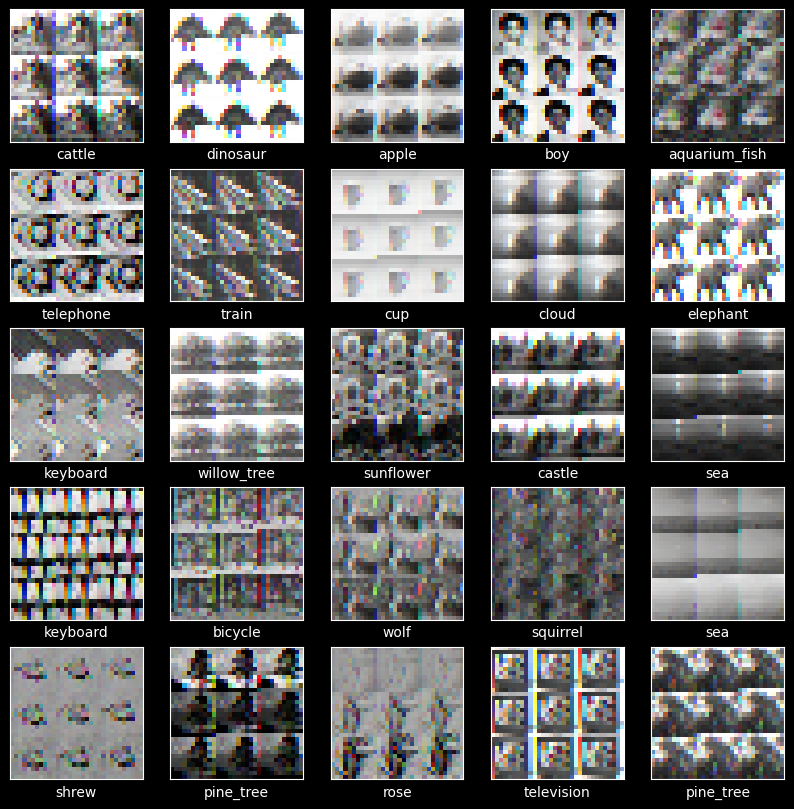

In [11]:
plot_images(train_data, train_fine_labels, label_fine)

Seems like we reshaped the data wrongly. We will try to reshape it again by separating each color profile (R, G, B) and restack them.

In [12]:
train_data = train[b'data']
test_data = test[b'data']

train_data_R = train_data[:, :1024].reshape(50000, 32, 32)
train_data_G = train_data[:, 1024:2048].reshape(50000, 32, 32)
train_data_B = train_data[:, 2048:].reshape(50000, 32, 32)

test_data_R = test_data[:, :1024].reshape(10000, 32, 32)
test_data_G = test_data[:, 1024:2048].reshape(10000, 32, 32)
test_data_B = test_data[:, 2048:].reshape(10000, 32, 32)

# Stack the data
train_data = np.stack((train_data_R, train_data_G, train_data_B), axis=3)
test_data = np.stack((test_data_R, test_data_G, test_data_B), axis=3)

print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


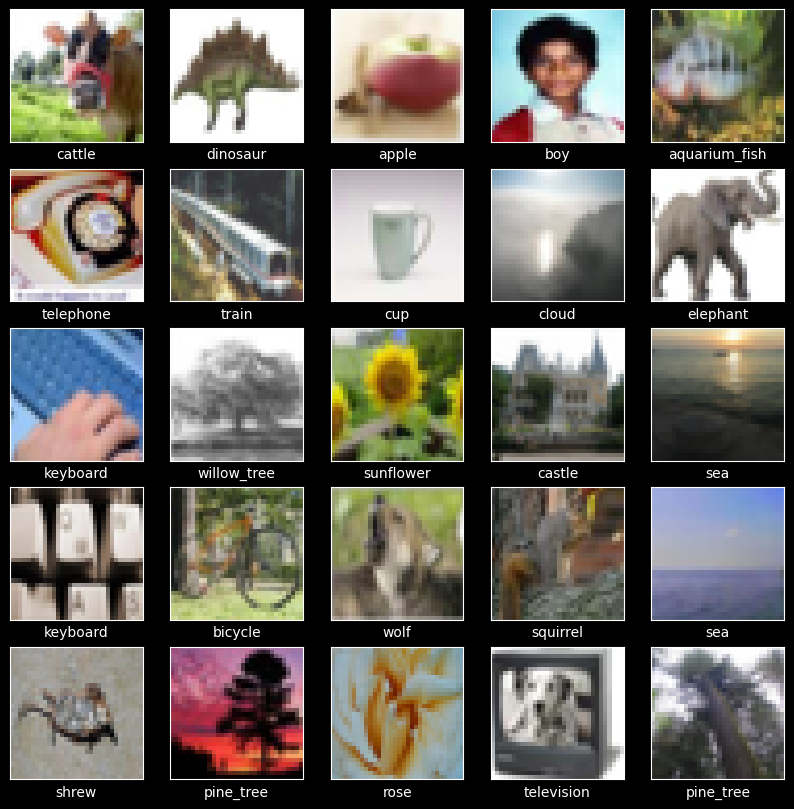

In [13]:
plot_images(train_data, train_fine_labels, label_fine)

In [14]:
print(f'Train Data Shape: {train_data.shape}\nTest Data Shape: {test_data.shape}')

Train Data Shape: (50000, 32, 32, 3)
Test Data Shape: (10000, 32, 32, 3)


The reason why we have to separate them like this instead of directly reshaping them is because the data were flatten before saving as text file.

Credit to: https://www.kaggle.com/code/yipengzhou3/cifar100-pytorch for doing the same 'wrong' approach to reshaping the data.

## **Data Preprocessing**

Since the image data's range is (0, 255), we will rescale it to (0, 1) to find the mean and standard deviation for normalization.

In [15]:
# Convert the data to float
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# Normalize the data
train_data /= 255.0
test_data /= 255.0

In [16]:
X_train, y_train = train_data, train_fine_labels
X_test, y_test = test_data, test_fine_labels

num_classes = 100
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [17]:
# Find mean and std
mean = X_train.mean(axis=(0, 1, 2), keepdims=True)
std = X_train.std(axis=(0, 1, 2), keepdims=True)

mean = tuple(mean.flatten())
std = tuple(std.flatten())

print(f'Mean: {mean}\nStd: {std}')

Mean: (0.32768, 0.32768, 0.32768)
Std: (0.30221897, 0.2838716, 0.27933034)


In [18]:
train_data = np.stack((train_data_R, train_data_G, train_data_B), axis=3)
test_data = np.stack((test_data_R, test_data_G, test_data_B), axis=3)

print(train_data.shape, test_data.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [19]:
X_train, y_train = train_data, train_fine_labels
X_test, y_test = test_data, test_fine_labels

print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


### **Creating the Transformers for dataset**

**Data Augmentation:**

We will apply the following to the dataset for training after training on the normal dataset;
- RandomCrop
- RandomHorizontalFlip
- RandomErasing

In [20]:
resizeKernel = (128, 128) # Any more than this will cause memory issues

#Transform data to Tensor
aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resizeKernel),
    transforms.RandomCrop(128, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std), # using the mean and standard deviation calculated above
    transforms.RandomErasing()
    ])

normal_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resizeKernel),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

In [21]:
# Apply the augmentation
noaugment_train_data = []
noaugment_train_label = []
for image, label in zip(X_train, y_train_encoded):
    noaugment_train_data.append(normal_transform(image))
    noaugment_train_label.append(label)

noaugment_test_data = []
noaugment_test_label = []
for image, label in zip(X_test, y_test_encoded):
    noaugment_test_data.append(normal_transform(image))
    noaugment_test_label.append(label)

noaugment_train_data = torch.stack(noaugment_train_data)
noaugment_test_data = torch.stack(noaugment_test_data)

# Change data from double to float
noaugment_train_data = noaugment_train_data.type(torch.FloatTensor)
noaugment_test_data = noaugment_test_data.type(torch.FloatTensor)

print(f'(Normal) Augmented Train Data Shape: {noaugment_train_data.shape}\n(Normal) Augmented Test Data Shape: {noaugment_test_data.shape}')

(Normal) Augmented Train Data Shape: torch.Size([50000, 3, 128, 128])
(Normal) Augmented Test Data Shape: torch.Size([10000, 3, 128, 128])


In [22]:
# Apply the augmentation
augmented_train_data = []
augmented_train_label = []
for image, label in zip(X_train, y_train_encoded):
    # image = image.reshape(32, 32, 3)
    # image = Image.fromarray(image)
    augmented_train_data.append(aug_transform(image))
    augmented_train_label.append(label)

augmented_test_data = []
augmented_test_label = []
for image, label in zip(X_test, y_test_encoded):
    # image = image.reshape(32, 32, 3)
    # image = Image.fromarray(image)
    augmented_test_data.append(normal_transform(image))
    augmented_test_label.append(label)

augmented_train_data = torch.stack(augmented_train_data)
augmented_test_data = torch.stack(augmented_test_data)

print(f'Augmented Train Data Shape: {augmented_train_data.shape}\nAugmented Test Data Shape: {augmented_test_data.shape}')

Augmented Train Data Shape: torch.Size([50000, 3, 128, 128])
Augmented Test Data Shape: torch.Size([10000, 3, 128, 128])


### **Creating the dataset and dataloader**

We have tried 4 different batch sizes by ourselves and did some research. We have found that the most optimal batch size is 32.

Reference: https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU

In [23]:
# Create the dataset
train_dataset = TensorDataset(noaugment_train_data, torch.Tensor(noaugment_train_label))
test_dataset = TensorDataset(noaugment_test_data, torch.Tensor(noaugment_test_label))

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
# Create the dataset
aug_train_dataset = TensorDataset(augmented_train_data, torch.Tensor(augmented_train_label))
aug_test_dataset = TensorDataset(augmented_test_data, torch.Tensor(augmented_test_label))

# Create the dataloader
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)
aug_test_loader = DataLoader(aug_test_dataset, batch_size=32, shuffle=False)

## **Model Training**

In [25]:
convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                num_labels=len(label_fine),
                                                                label2id=label2id,
                                                                id2label=id2label,
                                                                ignore_mismatched_sizes=True)

convnext_base.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(convnext_base.parameters(), lr=5e-5, weight_decay=1e-8)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
trainTestHistory_noaug = train_model([convnext_base], ['ConvNext_Base'], criterion, optimizer, lr_scheduler, 30, train_loader, test_loader, device)

ConvNext_Base -> |          | 0/30 [Time Elapsed: 00:00/?,?epoch/s]

Training -> Epoch 1/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 1/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Training -> Epoch 2/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 2/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Training -> Epoch 3/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 3/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Early Stopping counter: 1 out of 3


Training -> Epoch 4/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 4/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Early Stopping counter: 2 out of 3


Training -> Epoch 5/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 5/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Early Stopping counter: 3 out of 3
Early stopping at epoch 5


In [27]:
trainTestHistory_aug = train_model([convnext_base], ['ConvNext_Base'], criterion, optimizer, lr_scheduler, 30, aug_train_loader, aug_test_loader, device)

ConvNext_Base -> |          | 0/30 [Time Elapsed: 00:00/?,?epoch/s]

Training -> Epoch 1/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 1/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Training -> Epoch 2/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 2/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Early Stopping counter: 1 out of 3


Training -> Epoch 3/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 3/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Early Stopping counter: 2 out of 3


Training -> Epoch 4/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

Testing -> Epoch 4/30 |          | 0/313 [Time Elapsed: 00:00/?,?batch/s] 

Early Stopping counter: 3 out of 3
Early stopping at epoch 4


In [28]:
trainTestHistory = concatenateDict(trainTestHistory_noaug, trainTestHistory_aug)

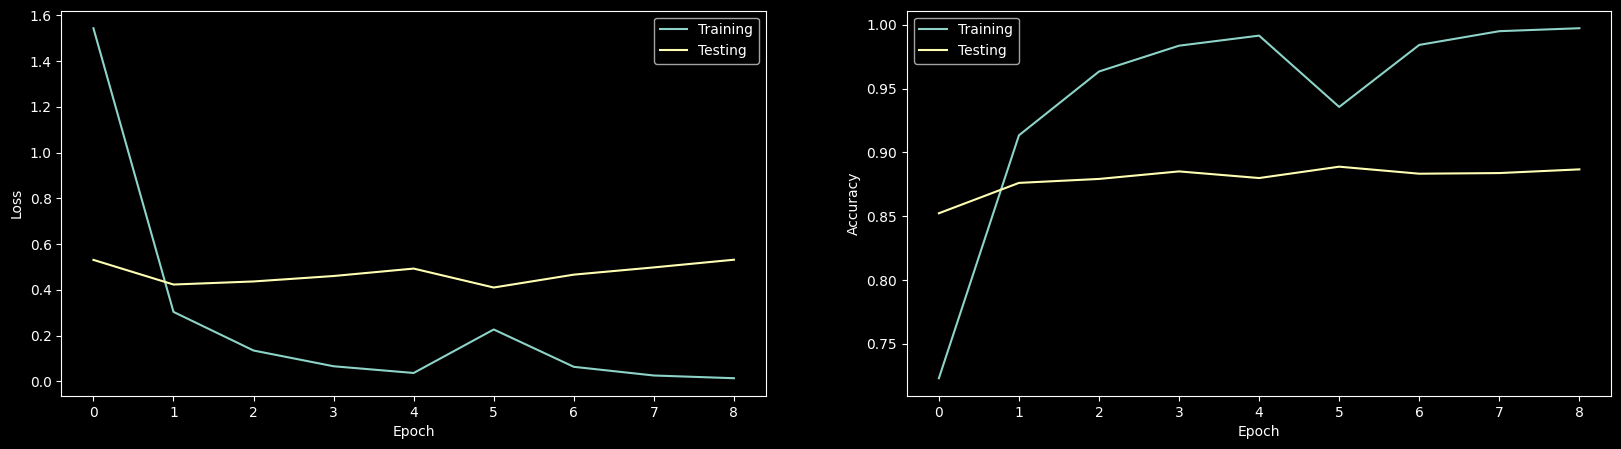

In [29]:
lossAccPlot(trainTestHistory, ['ConvNext_Base'])

In [30]:
printTestAcc(trainTestHistory, ['ConvNext_Base'])

ConvNext_Base -> Last Test Accuracy: 0.8867 
                Max Test Accuracy: 0.8888 (Epoch:5)


In [31]:
save_model([convnext_base], ['ConvNext_Base'], trainTestHistory, 'models/beforeTuning')

del convnext_base, trainTestHistory_noaug, trainTestHistory_aug, trainTestHistory
del criterion, optimizer, lr_scheduler
torch.cuda.empty_cache()

## **Hyperparameters Tuning**

In [3]:
# Tuning optimizer's learning rate
lr_list = [1e-5, 1e-4, 1e-3]
weight_decay_list = [1e-8, 1e-7, 1e-6]

In [33]:
for lr in lr_list:
    for weight_decay in weight_decay_list:
        model = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                num_labels=len(label_fine),
                                                                label2id=label2id,
                                                                id2label=id2label,
                                                                ignore_mismatched_sizes=True)
        
        model.to(device)

        print(f'Learning Rate: {lr}\nWeight Decay: {weight_decay}')
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        noaug_history = train_model([model], ['ConvNext_Base'], criterion, optimizer, lr_scheduler, 30, train_loader, test_loader, device, verbose=False)
        aug_history = train_model([model], ['ConvNext_Base'], criterion, optimizer, lr_scheduler, 30, aug_train_loader, aug_test_loader, device, verbose=False)
        mixed_history = concatenateDict(noaug_history, aug_history)
        save_model([model], ['ConvNext_Base'], mixed_history, f'models/ConvNext_Base_lr_{lr}_weight_decay_{weight_decay}')

        del optimizer, criterion, lr_scheduler, noaug_history, aug_history, mixed_history, model
        torch.cuda.empty_cache()
        print('-'*50)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 1e-05
Weight Decay: 1e-08
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 1e-05
Weight Decay: 1e-07
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 1e-05
Weight Decay: 1e-06
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 0.0001
Weight Decay: 1e-08
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 0.0001
Weight Decay: 1e-07
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 0.0001
Weight Decay: 1e-06
Early Stopping counter: 1 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 0.001
Weight Decay: 1e-08
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 0.001
Weight Decay: 1e-07
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Learning Rate: 0.001
Weight Decay: 1e-06
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
Early Stopping counter: 1 out of 3
Early Stopping counter: 2 out of 3
Early Stopping counter: 3 out of 3
--------------------------------------------------


In [12]:
print('Before Tuning')
printTestAcc(loadJSON('models/beforeTuning/ConvNext_Base_EpochDict.json'), ['ConvNext_Base'], add_name='lr_5e-5_weight_decay_1e-8')
print('-'*20)

print('After Tuning')
best_acc = 0.0
for lr in lr_list:
    for weight_decay in weight_decay_list:
        path = f'models/ConvNext_Base_lr_{lr}_weight_decay_{weight_decay}/ConvNext_Base_EpochDict.json'
        accDict = loadJSON(path)
        printTestAcc(accDict, ['ConvNext_Base'], add_name=f'lr_{lr}_weight_decay_{weight_decay}')
        acc = accDict["Test Accuracy_ConvNext_Base"][-1]
        if acc > best_acc:
            best_acc = acc
            best_path = path
            best_lr, best_weight_decay = lr, weight_decay

print('-'*20)
print('Best Model')
printTestAcc(loadJSON(best_path), ['ConvNext_Base'], add_name=f'lr_{best_lr}_weight_decay_{best_weight_decay}')

Before Tuning
ConvNext_Base_lr_5e-5_weight_decay_1e-8 -> Last Test Accuracy: 0.8867 
                Max Test Accuracy: 0.8888 (Epoch:5)
--------------------
After Tuning
ConvNext_Base_lr_1e-05_weight_decay_1e-08 -> Last Test Accuracy: 0.8559 
                Max Test Accuracy: 0.8595 (Epoch:10)
ConvNext_Base_lr_1e-05_weight_decay_1e-07 -> Last Test Accuracy: 0.8585 
                Max Test Accuracy: 0.8606 (Epoch:10)
ConvNext_Base_lr_1e-05_weight_decay_1e-06 -> Last Test Accuracy: 0.8594 
                Max Test Accuracy: 0.8616 (Epoch:9)
ConvNext_Base_lr_0.0001_weight_decay_1e-08 -> Last Test Accuracy: 0.8922 
                Max Test Accuracy: 0.895 (Epoch:5)
ConvNext_Base_lr_0.0001_weight_decay_1e-07 -> Last Test Accuracy: 0.898 
                Max Test Accuracy: 0.8987 (Epoch:7)
ConvNext_Base_lr_0.0001_weight_decay_1e-06 -> Last Test Accuracy: 0.8915 
                Max Test Accuracy: 0.894 (Epoch:8)
ConvNext_Base_lr_0.001_weight_decay_1e-08 -> Last Test Accuracy: 0.8014 
    

The best parameters we got was learning rate of 0.0001 (1e-4) and weight decay of 1e-7.

In [28]:
convnext_base = AutoModelForImageClassification.from_pretrained("facebook/convnext-base-224",
                                                                num_labels=len(label_fine),
                                                                label2id=label2id,
                                                                id2label=id2label,
                                                                ignore_mismatched_sizes=True)

convnext_base.to(device)

print(f'Number of parameters: {sum(p.numel() for p in convnext_base.parameters() if p.requires_grad)}')

# Memory Allocated in GB
print(f'Memory Allocated: {torch.cuda.memory_allocated(device)/(1024**3):.2f} GB')

del convnext_base
torch.cuda.empty_cache()

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 87668964
Memory Allocated: 0.33 GB


## **Swin Transformers**

In [25]:
from transformers import Swinv2ForImageClassification, AutoImageProcessor

swinimgpro = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
swin = Swinv2ForImageClassification.from_pretrained('microsoft/swinv2-base-patch4-window8-256')

swinimgpro.to(device)
swin.to(device)

print(f'Number of parameters: {sum(p.numel() for p in swin.parameters() if p.requires_grad)}')

# Memory Allocated in GB
print(f'Memory Allocated: {torch.cuda.memory_allocated(device)/(1024**3):.2f} GB')

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([100, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of parameters: 86996316
Memory Allocated: 0.32 GB


In [26]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(swin.parameters(), lr=1e-4, weight_decay=1e-7)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [27]:
trainTestHistory_noaug = train_model([swin], ['Swin'], criterion, optimizer, lr_scheduler, 30, train_loader, test_loader, device, swin=swinimgpro)

Swin -> |          | 0/30 [Time Elapsed: 00:00/?,?epoch/s]

Training -> Epoch 1/30 |          | 0/1563 [Time Elapsed: 00:00/?,?batch/s] 

RuntimeError: The size of tensor a (16) must match the size of tensor b (64) at non-singleton dimension 3

In [ ]:
trainTestHistory_aug = train_model([swin], ['Swin'], criterion, optimizer, lr_scheduler, 30, aug_train_loader, aug_test_loader, device, swin=swinimgpro)

In [ ]:
trainTestHistory = concatenateDict(trainTestHistory_noaug, trainTestHistory_aug)

In [ ]:
lossAccPlot(trainTestHistory, ['Swin'])

In [ ]:
printTestAcc(trainTestHistory, ['Swin'])